In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils import data
import matplotlib.pyplot as plt

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.1307, ), (.3081, ))])
train_data = datasets.MNIST("~/.pytorch", transform=transform, download=True)
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

In [26]:
print(train_data[0][0].size())
print(train_data[0][0].max())
print(train_data[0][0].min())

torch.Size([1, 28, 28])
tensor(2.8215)
tensor(-0.4242)


In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
         
        # hardcoded channels
        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, 3, stride=2), 
                                        nn.ELU(), nn.Dropout(p=0.25),
                                        nn.Conv2d(32, 64, 3, stride=2),
                                        nn.ELU(), nn.Dropout(p=0.25))
        
        self.clf = nn.Sequential(nn.Linear(64*6*6, 1))
        
              
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_block(x)
        x = x.view(-1, 64*6*6)
        x = self.clf(x)
        return x

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64, 3),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ELU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2), 
            nn.ELU()
        )
        
    def forward(self, z):
        x = self.model(z.view(-1, 100, 1, 1))
        return x

    @torch.no_grad()
    def generate(self):
        z = torch.randn(batch_size, 100)
        z = z.to(self.model[0].weight.device)
        raw = self.forward(z)
        return raw.clamp_(-0.4242, 2.8215) 

In [29]:
D = Discriminator()
G = Generator()

D.to(device)
G.to(device)


print(D)

print("------------------")

print(G)


opt_D = torch.optim.Adam(D.parameters(), lr=1e-3)
opt_G = torch.optim.Adam(G.parameters(), lr=1e-3)

Discriminator(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.25, inplace=False)
  )
  (clf): Sequential(
    (0): Linear(in_features=2304, out_features=1, bias=True)
  )
)
------------------
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ELU(alpha=1.0)
  )
)


In [30]:
criterion = nn.BCEWithLogitsLoss()

In [31]:
def update_D(D, G, x, y, noise, criterion):
    device = next(G.parameters()).device
    x = x.to(device)      
    label = torch.ones(y.size())
    label = label.to(device)
    out_real = D(x).view(-1)
    err_D_real = criterion(out_real, label)
            
    out_fake = G(noise).reshape(batch_size, -1, 28, 28)
    label = torch.zeros(batch_size)
    label = label.to(device)
    out_ = D(out_fake).view(-1)
    err_D_fake = criterion(out_, label)
    
    err_D = err_D_real + err_D_fake
    return err_D

def update_G(D, G, noise, criterion):
    device = next(G.parameters()).device
    out_fake = G(noise).reshape(batch_size, -1, 28, 28)
    label = torch.ones(batch_size)
    label = label.to(device)
    pred = D(out_fake).view(-1)
    err_G = criterion(pred, label)
    return err_G

def update_Gan(loader, D, G, opt_D, opt_G, criterion):
    errors_D = []
    errors_G = []
    device = next(G.parameters()).device
         
    for i, (x, y) in enumerate(loader):
        noise = torch.randn(batch_size, 100, 1, 1)
        noise = noise.to(device)
        
        G.requires_grad = False
        opt_D.zero_grad()
        err_D = update_D(D, G, x, y, noise, criterion)
        err_D.backward()
        errors_D.append(err_D.item())
        opt_D.step()
        
        G.requires_grad = True
        opt_G.zero_grad()
        err_G = update_G(D, G, noise, criterion)
        err_G.backward()
        errors_G.append(err_G.item())
        opt_G.step()
        
    return errors_D, errors_G


def train_gan(D, G, opt_D, opt_G, criterion, loader, nr_epochs=50, every=10):
    for epoch in range(nr_epochs):
        if epoch % every == 0:
            G.eval()
            samples = G.generate().cpu().detach().numpy()
            plot_digits(samples)
            
        D.train()
        G.train()
        errs_D, errs_G = update_Gan(loader, D, G, opt_D, opt_G, criterion)
        print(f"epoch: {epoch+1} ,   err_D: {sum(errs_D)/len(errs_D)},   err_G: {sum(errs_G)/len(errs_G)}")

In [32]:
def plot_digits(samples):
    fig = plt.figure(figsize=(16, 8))
    for i in range(10):
        fig.add_subplot(1, 10, i+1)
        plt.imshow(samples[i][0], cmap="gray")
    plt.show()

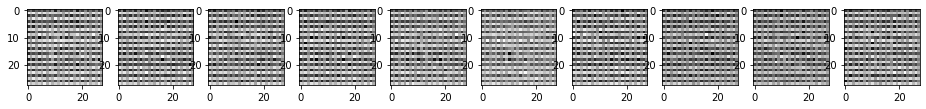

epoch: 1 ,   err_D: 0.3066403580288877,   err_G: 8.48046382124236
epoch: 2 ,   err_D: 0.4826124644280274,   err_G: 6.643515114845243
epoch: 3 ,   err_D: 0.309754481983941,   err_G: 6.8716552308373355
epoch: 4 ,   err_D: 0.3212943100400253,   err_G: 6.876424902283561
epoch: 5 ,   err_D: 0.40735139055594577,   err_G: 5.8634915969519215
epoch: 6 ,   err_D: 0.47776985224852686,   err_G: 5.310177201401196
epoch: 7 ,   err_D: 0.5268819962642086,   err_G: 4.577423248209679
epoch: 8 ,   err_D: 0.5299650105649728,   err_G: 4.055903781960005
epoch: 9 ,   err_D: 0.5562896095613427,   err_G: 3.7856010892497958
epoch: 10 ,   err_D: 0.5893770960062298,   err_G: 3.4998650347500213


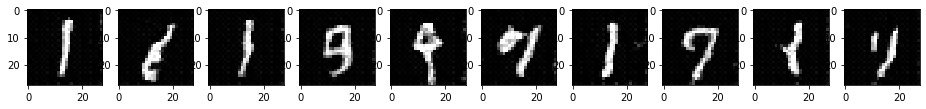

epoch: 11 ,   err_D: 0.6144534039980313,   err_G: 3.2913520600495816
epoch: 12 ,   err_D: 0.647523668020773,   err_G: 3.016725219261926
epoch: 13 ,   err_D: 0.6954406738471883,   err_G: 2.8782703192757646
epoch: 14 ,   err_D: 0.7382980192393891,   err_G: 2.6470257050192942
epoch: 15 ,   err_D: 0.7742975776764884,   err_G: 2.4418581126849532
epoch: 16 ,   err_D: 0.8064082864759319,   err_G: 2.28279342948755
epoch: 17 ,   err_D: 0.8300435982787533,   err_G: 2.1792893081839915
epoch: 18 ,   err_D: 0.8503737949422682,   err_G: 2.117616821199592
epoch: 19 ,   err_D: 0.8657466082938953,   err_G: 2.076545861484145
epoch: 20 ,   err_D: 0.8763824317818766,   err_G: 2.0292323539251966


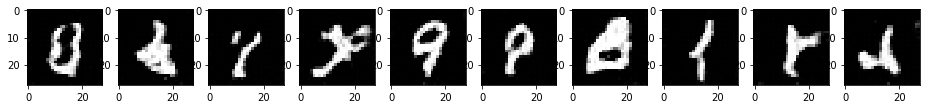

epoch: 21 ,   err_D: 0.8882914981735286,   err_G: 1.9835654058690264
epoch: 22 ,   err_D: 0.8976473437189293,   err_G: 1.9510480162939792
epoch: 23 ,   err_D: 0.9141530294789434,   err_G: 1.925937332832483
epoch: 24 ,   err_D: 0.9146548530885151,   err_G: 1.871349115361537
epoch: 25 ,   err_D: 0.9245124083719274,   err_G: 1.8999236991156394
epoch: 26 ,   err_D: 0.9348364356738418,   err_G: 1.813600603959708
epoch: 27 ,   err_D: 0.9425862802625465,   err_G: 1.795637367757907
epoch: 28 ,   err_D: 0.9520744830052227,   err_G: 1.7559305536213206
epoch: 29 ,   err_D: 0.9627637675067763,   err_G: 1.7352129431929924
epoch: 30 ,   err_D: 0.9729459573592204,   err_G: 1.7146786056729013


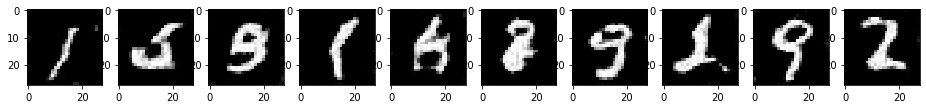

epoch: 31 ,   err_D: 0.9831479648028864,   err_G: 1.6795757135856888
epoch: 32 ,   err_D: 0.9821101591658237,   err_G: 1.65818621138774
epoch: 33 ,   err_D: 0.9905178517675095,   err_G: 1.6642161621086633
epoch: 34 ,   err_D: 0.99719054212194,   err_G: 1.6288471674359937
epoch: 35 ,   err_D: 0.9956053391194293,   err_G: 1.6425867331053403
epoch: 36 ,   err_D: 1.0113904563221596,   err_G: 1.6188925715016405
epoch: 37 ,   err_D: 0.9997479275091371,   err_G: 1.614558394339039
epoch: 38 ,   err_D: 1.0146861794406672,   err_G: 1.5677000613990368
epoch: 39 ,   err_D: 1.0194552999569664,   err_G: 1.580466294720737
epoch: 40 ,   err_D: 1.0241410835846654,   err_G: 1.5477778237384519


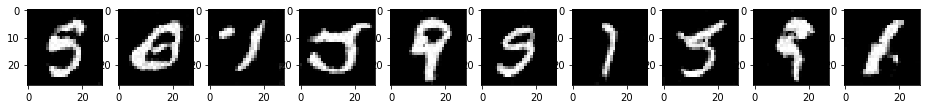

epoch: 41 ,   err_D: 1.0292607158867282,   err_G: 1.5513663047285222
epoch: 42 ,   err_D: 1.0336290163907416,   err_G: 1.5203434763940922
epoch: 43 ,   err_D: 1.0350226234398416,   err_G: 1.5339803891395456
epoch: 44 ,   err_D: 1.042527191293265,   err_G: 1.511577184584095
epoch: 45 ,   err_D: 1.0457160582166236,   err_G: 1.514736566080976
epoch: 46 ,   err_D: 1.0518329285228176,   err_G: 1.4817166206424932
epoch: 47 ,   err_D: 1.0440475545458194,   err_G: 1.505855038031332
epoch: 48 ,   err_D: 1.0540765361872309,   err_G: 1.482323964076764
epoch: 49 ,   err_D: 1.044856596412435,   err_G: 1.495572001440947


In [ ]:
train_gan(D, G, opt_D, opt_G, criterion, train_loader)

In [ ]:
G.eval()
samples = G.generate().cpu().detach().numpy()
plot_digits(samples)